# LDA를 이용한 Topic modeling
## 목차
    1. Data 탐색  
        1-1 데이터 로드  

    2. TF-IDF Matrix  
        2-1 CountVectorizer를 이용한 term-docs TF Matrix 생성    
        2-2 IDF 생성 및 계산  
        2-3 TF-IDF Matrix 생성 및 계산  

    3. Topic Modeling
        3-1 LDA(LDA(Latent Dirichlet Allocation)
        3-2 토픽의 수에 따른 토픽 및 분포 확인
            *토픽 수 5개
            *토픽 수 4개
            *토픽 수 3개
        3-3 최적의 Topic 수를 선정 및 선정 이유
        3-4 최종 Topic Labeling (Keyword들을 고려하여 적합한 이름을 부여)

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

from math import log
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns

## 1. 데이터 탐색
### 1-1 데이터 로드

In [2]:
f = open('./data/data_week10.txt','r')

docs = []
while True:
    line = f.readline()
    if line == '':
        break    
    else:
        docs.append(line.strip())
    
f.close()
docs

['cute kitty',
 'eat rice cake',
 'kitty hamster',
 'eat bread',
 'rice bread cake',
 'cute hamster eat bread cake']

* docs리스트 내의 하나의 요소가 1개의 문서이므로 추후 만들 Matrix의 index 설정

In [3]:
docs_index = ['Docs'+str(i) for i in range(1,7)]
docs_index

['Docs1', 'Docs2', 'Docs3', 'Docs4', 'Docs5', 'Docs6']

## 2. TF-IDF Matrix
### 2-1 CountVectorizer를 이용한 term-docs TF Matrix 생성

In [4]:
vectorizer = CountVectorizer(stop_words='english')
TFM = vectorizer.fit_transform(docs)

print(vectorizer.get_feature_names())
print(TFM.toarray().tolist())

['bread', 'cake', 'cute', 'eat', 'hamster', 'kitty', 'rice']
[[0, 0, 1, 0, 0, 1, 0], [0, 1, 0, 1, 0, 0, 1], [0, 0, 0, 0, 1, 1, 0], [1, 0, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 0, 1], [1, 1, 1, 1, 1, 0, 0]]


In [5]:
TF = pd.DataFrame(TFM.toarray().tolist(), index= docs_index, columns= vectorizer.get_feature_names())
for i in TF.columns:
    print(i, TF[i].sum())
TF

bread 3
cake 3
cute 2
eat 3
hamster 2
kitty 2
rice 2


,bread,cake,cute,eat,hamster,kitty,rice
Docs1,0,0,1,0,0,1,0
Docs2,0,1,0,1,0,0,1
Docs3,0,0,0,0,1,1,0
Docs4,1,0,0,1,0,0,0
Docs5,1,1,0,0,0,0,1
Docs6,1,1,1,1,1,0,0


### 2-2 IDF 생성 및 계산
    idf(d,t)=log(n / (1+df(t)) )
    N = 6,N : 전체 docs의 수
    df(t : term) : 각 단어가 속한 문서의 수

    df(bread)  3
    df(cake) : 3
    df(cute) : 2
    df(eat) :  3
    df(hamster): 2
    df(kitty): 2
    df(rice) : 2

In [6]:
terms = vectorizer.get_feature_names()
terms

['bread', 'cake', 'cute', 'eat', 'hamster', 'kitty', 'rice']

In [7]:
N = 6 
df_t = [3,3,2,3,2,2,2]
idf= []
# 각 단어에 대한 idf값 계산
for i, dft in zip(terms, df_t):
    idf.append(round(log( N / (1+dft ) ),4))
idf

[0.4055, 0.4055, 0.6931, 0.4055, 0.6931, 0.6931, 0.6931]

In [8]:
idf= np.array(idf)
idf

array([0.4055, 0.4055, 0.6931, 0.4055, 0.6931, 0.6931, 0.6931])

In [9]:
df_idf = pd.DataFrame(data=idf.transpose(), index=terms, columns=['idf'])
df_idf

,idf
bread,0.4055
cake,0.4055
cute,0.6931
eat,0.4055
hamster,0.6931
kitty,0.6931
rice,0.6931


### 2-3 TF-IDF Matrix 생성 및 계산 
* TF-IDF 계산 (df * idf = TF * IDF)

In [10]:
TF_T = TF.transpose()
# TF-IDF matrix 생성
tf_idf = pd.DataFrame(index = terms, columns=TF_T.columns)
tf_idf

# TF-IDF 계산 (df * idf = TF * IDF)
for i in range(7):
    tf_idf.iloc[i] = round(TF_T.iloc[i]*idf[i],4)
tf_idf

,Docs1,Docs2,Docs3,Docs4,Docs5,Docs6
bread,0.0,0.0,0.0,0.4055,0.4055,0.4055
cake,0.0,0.4055,0.0,0.0,0.4055,0.4055
cute,0.6931,0.0,0.0,0.0,0.0,0.6931
eat,0.0,0.4055,0.0,0.4055,0.0,0.4055
hamster,0.0,0.0,0.6931,0.0,0.0,0.6931
kitty,0.6931,0.0,0.6931,0.0,0.0,0.0
rice,0.0,0.6931,0.0,0.0,0.6931,0.0


## 3. Topic Modeling
### 3-1 LDA
    * Topic 개수(1 ~ 30개)에 따른 perplexity 계산


[Text(0, 0.5, 'perplexity'), Text(0.5, 0, 'number of topics')]

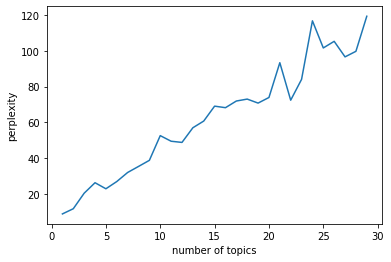

In [11]:
x,y =[], []
for i in range(1,30):
    lda = LatentDirichletAllocation(n_components=i, random_state=777, verbose=0, learning_method='batch', max_iter=100)
    lda.fit(TFM)
    
#     print("\n 토픽 수",i,"개 Topics in LDA model (Perplexity={}):".format(lda.perplexity(TFM)))
    x.append(i)
    y.append(lda.perplexity(TFM))
line_plot = sns.lineplot(x=x, y=y)
line_plot.set(xlabel='number of topics', ylabel='perplexity')

    위와같이 topic의 수가 증가하면 perplexity가 증가하는 것을 볼 수 있습니다.
    토픽이 5개 일때, perplexity가 토픽 4개일때보다 작은 것을 확인했습니다.
    따라서 토픽의 수를 5로 설정했습니다.

### 3-2 토픽의 수에 따른 토픽 및 분포 확인 
#### 토픽의 수 5개

In [31]:
lda = LatentDirichletAllocation(n_components=5)
lda.fit(TFM)

print("\nTopics in LDA model (Perplexity={}):".format(lda.perplexity(TFM)),'\n')
feature_names = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    message = "Topic #%d: " % topic_idx
    message += ", ".join([feature_names[i] for i in topic.argsort()[:-10 -1:-1]])
    print(message)


Topics in LDA model (Perplexity=24.650451730389843): 

Topic #0: bread, eat, cake, kitty, hamster, cute, rice
Topic #1: hamster, kitty, bread, eat, cake, cute, rice
Topic #2: cake, rice, eat, bread, kitty, hamster, cute
Topic #3: cute, kitty, bread, eat, cake, hamster, rice
Topic #4: eat, bread, cake, hamster, cute, kitty, rice


위와 같이 Topic#2 와 Topic#3이 같은 토픽임을 확인했습니다.

In [32]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, TFM, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.143590 -0.056351       1        1  31.524411
4     -0.024743  0.010533       2        1  29.592834
0     -0.086543  0.063883       3        1  12.988104
3      0.127438 -0.009031       4        1  12.947326
1      0.127437 -0.009034       5        1  12.947325, topic_info=      Term      Freq     Total Category  logprob  loglift
5    kitty  1.000000  1.000000  Default   7.0000   7.0000
4  hamster  2.000000  2.000000  Default   6.0000   6.0000
2     cute  2.000000  2.000000  Default   5.0000   5.0000
0    bread  2.000000  2.000000  Default   4.0000   4.0000
3      eat  2.000000  2.000000  Default   3.0000   3.0000
6     rice  2.000000  2.000000  Default   2.0000   2.0000
1     cake  2.000000  2.000000  Default   1.0000   1.0000
6     rice  1.595371  2.141073   Topic1  -1.2117   0.8602
1     cake  1.595604  2.927253   Topic1  -1.2116   0.5476
3      eat  0.866511  2.849362   Topic1  -1.8221  -0.0360
0    bread  0.866510  2.849362   Topic1  -1.8221  -0.0360
5    kitty  0.145052  1.985049   Topic1  -3.6095  -1.4619
2     cute  0.145051  2.123949   Topic1  -3.6095  -1.5295
4  hamster  0.145051  2.123953   Topic1  -3.6095  -1.5295
2     cute  0.942777  2.123949   Topic2  -1.6745   0.4054
4  hamster  0.942777  2.123953   Topic2  -1.6745   0.4054
3      eat  0.943775  2.849362   Topic2  -1.6734   0.1127
0    bread  0.943775  2.849362   Topic2  -1.6734   0.1127
1     cake  0.943169  2.927253   Topic2  -1.6741   0.0851
5    kitty  0.157257  1.985049   Topic2  -3.4654  -1.3179
6     rice  0.157252  2.141073   Topic2  -3.4655  -1.3936
0    bread  0.780120  2.849362   Topic3  -1.0404   0.7457
3      eat  0.780118  2.849362   Topic3  -1.0404   0.7457
5    kitty  0.129549  1.985049   Topic3  -2.8358  -0.6882
2     cute  0.129547  2.123949   Topic3  -2.8358  -0.7559
4  hamster  0.129547  2.123953   Topic3  -2.8358  -0.7559
6     rice  0.129543  2.141073   Topic3  -2.8358  -0.7639
1     cake  0.129553  2.927253   Topic3  -2.8357  -1.0766
5    kitty  0.776600  1.985049   Topic4  -1.0418   1.1058
2     cute  0.777112  2.123949   Topic4  -1.0411   1.0388
4  hamster  0.129460  2.123953   Topic4  -2.8333  -0.7534
6     rice  0.129453  2.141073   Topic4  -2.8334  -0.7615
0    bread  0.129478  2.849362   Topic4  -2.8332  -1.0471
3      eat  0.129478  2.849362   Topic4  -2.8332  -1.0471
1     cake  0.129463  2.927253   Topic4  -2.8333  -1.0741
5    kitty  0.776591  1.985049   Topic5  -1.0418   1.1058
4  hamster  0.777117  2.123953   Topic5  -1.0411   1.0388
2     cute  0.129461  2.123949   Topic5  -2.8333  -0.7534
6     rice  0.129454  2.141073   Topic5  -2.8334  -0.7615
0    bread  0.129479  2.849362   Topic5  -2.8332  -1.0470
3      eat  0.129479  2.849362   Topic5  -2.8332  -1.0470
1     cake  0.129464  2.927253   Topic5  -2.8333  -1.0741, token_table=      Topic      Freq     Term
term                          
0         1  0.350956    bread
0         2  0.350956    bread
0         3  0.350956    bread
1         1  0.683234     cake
1         2  0.341617     cake
2         2  0.470821     cute
2         4  0.470821     cute
3         1  0.350956      eat
3         2  0.350956      eat
3         3  0.350956      eat
4         2  0.470820  hamster
4         5  0.470820  hamster
5         4  0.503766    kitty
5         5  0.503766    kitty
6         1  0.934111     rice, R=7, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 4, 2])

이를 시각화해 본 결과, 위와 같이 4, 5의 토픽이 겹쳐있는것을 확인했고,   
토픽1을 제외하고 토픽2, 3, 4, 5는 해당 토픽 내의 예상 용어 빈도가 표시되지 않음을 확인했습니다.  
따라서 토픽의 수를 줄여야 겠다고 생각했습니다.  

### 토픽 수 4개

In [14]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
lda = LatentDirichletAllocation(n_components=4)
lda.fit(TFM)

print("\nTopics in LDA model (Perplexity={}):".format(lda.perplexity(TFM)),'\n')
feature_names = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    message = "Topic #%d: " % topic_idx
    message += ", ".join([feature_names[i] for i in topic.argsort()[:-10 -1:-1]])
    print(message)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, TFM, vectorizer)


Topics in LDA model (Perplexity=21.296770215657524): 

Topic #0: bread, cake, rice, hamster, eat, cute, kitty
Topic #1: eat, cake, rice, hamster, bread, cute, kitty
Topic #2: bread, eat, hamster, cute, cake, kitty, rice
Topic #3: kitty, cute, hamster, cake, eat, bread, rice


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.031462  0.090357       1        1  42.406389
0     -0.071296 -0.037844       2        1  19.666899
1     -0.071295 -0.037842       3        1  19.666893
3      0.174053 -0.014670       4        1  18.259819, topic_info=      Term      Freq     Total Category  logprob  loglift
5    kitty  1.000000  1.000000  Default   7.0000   7.0000
6     rice  2.000000  2.000000  Default   6.0000   6.0000
1     cake  2.000000  2.000000  Default   5.0000   5.0000
2     cute  2.000000  2.000000  Default   4.0000   4.0000
3      eat  2.000000  2.000000  Default   3.0000   3.0000
0    bread  2.000000  2.000000  Default   2.0000   2.0000
4  hamster  2.000000  2.000000  Default   1.0000   1.0000
4  hamster  1.650876  2.183691   Topic1  -1.4740   0.5782
0    bread  1.667664  2.888076   Topic1  -1.4639   0.3087
3      eat  1.667663  2.888082   Topic1  -1.4639   0.3087
2     cute  0.926687  2.092062   Topic1  -2.0515   0.0436
1     cake  0.921426  2.846264   Topic1  -2.0572  -0.2700
5    kitty  0.188791  1.998701   Topic1  -3.6425  -1.5017
6     rice  0.185979  2.103124   Topic1  -3.6575  -1.5677
6     rice  0.877322  2.103124   Topic2  -1.3379   0.7519
1     cake  0.881123  2.846264   Topic2  -1.3335   0.4537
0    bread  0.882091  2.888076   Topic2  -1.3324   0.4402
5    kitty  0.175636  1.998701   Topic2  -2.9463  -0.8056
2     cute  0.175695  2.092062   Topic2  -2.9460  -0.8509
4  hamster  0.175767  2.183691   Topic2  -2.9456  -0.8934
3      eat  0.175737  2.888082   Topic2  -2.9457  -1.1731
6     rice  0.877314  2.103124   Topic3  -1.3379   0.7519
1     cake  0.881116  2.846264   Topic3  -1.3335   0.4537
3      eat  0.882099  2.888082   Topic3  -1.3324   0.4402
5    kitty  0.175638  1.998701   Topic3  -2.9463  -0.8056
2     cute  0.175697  2.092062   Topic3  -2.9460  -0.8509
4  hamster  0.175769  2.183691   Topic3  -2.9456  -0.8934
0    bread  0.175739  2.888076   Topic3  -2.9457  -1.1731
5    kitty  1.458636  1.998701   Topic4  -0.7552   1.3855
2     cute  0.813984  2.092062   Topic4  -1.3386   0.7565
4  hamster  0.181279  2.183691   Topic4  -2.8405  -0.7883
6     rice  0.162509  2.103124   Topic4  -2.9498  -0.8600
1     cake  0.162598  2.846264   Topic4  -2.9492  -1.1620
0    bread  0.162582  2.888076   Topic4  -2.9493  -1.1767
3      eat  0.162582  2.888082   Topic4  -2.9493  -1.1767, token_table=      Topic      Freq     Term
term                          
0         1  0.692503    bread
0         2  0.346251    bread
1         1  0.351338     cake
1         2  0.351338     cake
1         3  0.351338     cake
2         1  0.477997     cute
2         4  0.477997     cute
3         1  0.692501      eat
3         3  0.346251      eat
4         1  0.915880  hamster
5         4  0.500325    kitty
6         2  0.475483     rice
6         3  0.475483     rice, R=7, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

토픽의 수 4개인 경우에도 토픽2개가 겹치는 것을 발견했습니다.  
겹치는 토픽 2개의 경우에 토픽의 수 5개의 경우처럼 예상 용어 빈도가 표시되지 않음을 확인했습니다.  
따라서 토픽의 수를 1개 더 줄여 아래와같이 토픽 수 3개로 설정했습니다.

### 토픽 수 3개

In [47]:
lda = LatentDirichletAllocation(n_components=3)
lda.fit(TFM)

print("\nTopics in LDA model (Perplexity={}):".format(lda.perplexity(TFM)),'\n')

feature_names = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    message = "Topic #%d: " % topic_idx
    message += ", ".join([feature_names[i] for i in topic.argsort()])
    print(message)
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, TFM, vectorizer)


Topics in LDA model (Perplexity=16.376124721954223): 

Topic #0: kitty, cute, hamster, rice, eat, bread, cake
Topic #1: rice, cake, bread, eat, cute, hamster, kitty
Topic #2: rice, kitty, cake, bread, eat, hamster, cute


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.117402 -0.025414       1        1  42.94067
2     -0.016279  0.042552       2        1  36.50214
1      0.133681 -0.017138       3        1  20.55719, topic_info=      Term      Freq     Total Category  logprob  loglift
5    kitty  1.000000  1.000000  Default   7.0000   7.0000
4  hamster  2.000000  2.000000  Default   6.0000   6.0000
2     cute  2.000000  2.000000  Default   5.0000   5.0000
6     rice  2.000000  2.000000  Default   4.0000   4.0000
1     cake  2.000000  2.000000  Default   3.0000   3.0000
0    bread  2.000000  2.000000  Default   2.0000   2.0000
3      eat  2.000000  2.000000  Default   1.0000   1.0000
6     rice  1.644258  2.112476   Topic1  -1.4906   0.5948
1     cake  1.654070  2.863671   Topic1  -1.4846   0.2965
0    bread  1.646758  2.864109   Topic1  -1.4891   0.2919
3      eat  1.646750  2.864109   Topic1  -1.4891   0.2919
5    kitty  0.235759  1.997531   Topic1  -3.4328  -1.2915
4  hamster  0.236171  2.100590   Topic1  -3.4311  -1.3401
2     cute  0.236148  2.197513   Topic1  -3.4312  -1.3853
2     cute  1.697400  2.197513   Topic2  -1.2963   0.7496
4  hamster  1.001886  2.100590   Topic2  -1.8235   0.2675
3      eat  0.999819  2.864109   Topic2  -1.8256  -0.0446
0    bread  0.999810  2.864109   Topic2  -1.8256  -0.0446
1     cake  0.992334  2.863671   Topic2  -1.8331  -0.0520
5    kitty  0.262595  1.997531   Topic2  -3.1626  -1.0213
6     rice  0.251521  2.112476   Topic2  -3.2056  -1.1203
5    kitty  1.499176  1.997531   Topic3  -0.8463   1.2950
4  hamster  0.862533  2.100590   Topic3  -1.3991   0.6919
2     cute  0.263966  2.197513   Topic3  -2.5832  -0.5373
6     rice  0.216698  2.112476   Topic3  -2.7805  -0.6952
0    bread  0.217540  2.864109   Topic3  -2.7766  -0.9957
3      eat  0.217540  2.864109   Topic3  -2.7766  -0.9957
1     cake  0.217268  2.863671   Topic3  -2.7779  -0.9968, token_table=      Topic      Freq     Term
term                          
0         1  0.698298    bread
0         2  0.349149    bread
1         1  0.698404     cake
1         2  0.349202     cake
2         2  0.910120     cute
3         1  0.698297      eat
3         2  0.349149      eat
4         2  0.476057  hamster
4         3  0.476057  hamster
5         3  0.500618    kitty
6         1  0.946756     rice, R=7, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

### 3-3  최적의 Topic 수를 선정 및 선정 이유
    최종적으로 제가 선정한 토픽의 수는 3개입니다.  
    왜냐하면, 토픽의 수가 5개, 4개인 경우에는 예상 용어 빈도가 표시되지 않는 토픽이 있음을 확인했습니다.  
    이에 예상 용어 빈도가 측정되지 않는 토픽의 경우에 토픽의 의미가 없을 것이라 판단하였습니다.
    이에 토픽의 수를 줄였고, 토픽의 수가 3개인 경우에는 겹치는 단어가 없으며, 모두 예상 용어 빈도가 존재하기 때문에
    최종적으로 토픽의 수를 3개로 선정했습니다.

### 3-4 최종 Topic Labeling (Keyword들을 고려하여 적합한 이름을 부여)


    최종적으로 선정한 3개의 토픽의 경우에 모든 토픽에서 다음과 같은 용어들이 예상 용어 빈도가 표시 되었습니다.
    이에 예상 빈도수가 높은 단어를 선택했습니다.
    토픽 1 : cake, bread, eat, rice
    토픽 2 : kitty 
    토픽 3 : cute 
    
    
    토픽 1에 대해서는 모든 단어의 빈도수가 동일하므로 모든 단어를 사용하여 eat rice cake and rice bread (한글 : 쌀 간식을 먹자!)

    토픽 2와 3의 경우에는 하나의 키워드씩만 선택할 수 있었습니다.
    토픽 2의 경우 kitty는 명사로 취급하여 용어 그대로 kitty를, 토픽3의 경우에 cute는 형용사 이기때문에 
    전체 명사(hamster, bread, cake, kitty) 중 term frequency가 높은 순서로 cute와 어울릴 수 있는 단어를 선택하려고 했습니다.
    (bread - cake, hamster, kitty 순으로 term frequency가 높았고, bread와 cake는 cute와 어울리지 않기때문에 제외했습니다.)
    하지만, 명사를 임의로 선택할 시에는 특정 문서와 완전히 같은 토픽이 되기 때문에 추가 단어를 선택하지 않았습니다.
    
    최종 Topic Labeling
    
    토픽 1 : eat rice bread and rice cake 
    토픽 2 : kitty
    토픽 3 : cute 
    

### 4. 추가 활동
    * term-topic Matrix
    * docs-topic Matrix

In [82]:
term_topic = pd.DataFrame(lda.components_.tolist(),columns=vectorizer.get_feature_names(), index = ['Topic1','Topic2','Topic3']).transpose()
term_topic

,Topic1,Topic2,Topic3
bread,2.334194,0.336154,1.329652
cake,2.344558,0.335732,1.319710
cute,0.334727,0.407893,2.257381
eat,2.334182,0.336154,1.329664
hamster,0.334760,1.332826,1.332413
kitty,0.334177,2.316597,0.349227
rice,2.330650,0.334852,0.334499


In [83]:
for topics in term_topic.columns:
    term_topic[topics] = term_topic[topics]/term_topic[topics].sum()
term_topic

,Topic1,Topic2,Topic3
bread,0.225586,0.062248,0.161120
cake,0.226588,0.062170,0.159916
cute,0.032349,0.075533,0.273537
eat,0.225585,0.062248,0.161122
hamster,0.032353,0.246810,0.161455
kitty,0.032296,0.428983,0.042317
rice,0.225243,0.062007,0.040533


In [84]:
docs_topic = pd.DataFrame(index = docs_index,columns = ['Topic1','Topic2','Topic3'])
docs_topic

,Topic1,Topic2,Topic3
Docs1,NaN,NaN,NaN
Docs2,NaN,NaN,NaN
Docs3,NaN,NaN,NaN
Docs4,NaN,NaN,NaN
Docs5,NaN,NaN,NaN
Docs6,NaN,NaN,NaN


In [85]:
Topics =   ['Topic1','Topic2','Topic3']

In [87]:
for Topic in Topics:
    for doc,doc_index in zip(docs,docs_index):
        P_dz = 0
        for term in doc.split():
            
            P_dz += term_topic.loc[term,Topic]
        docs_topic.loc[doc_index,Topic] = P_dz

In [88]:
docs_topic

,Topic1,Topic2,Topic3
Docs1,0.064646,0.504516,0.315855
Docs2,0.677416,0.186426,0.36157
Docs3,0.064649,0.675793,0.203772
Docs4,0.451171,0.124497,0.322242
Docs5,0.677417,0.186426,0.361569
Docs6,0.74246,0.50901,0.91715


In [89]:
for i in docs_topic.columns:
    docs_topic[i] = docs_topic[i]/docs_topic[i].sum()

In [90]:
docs_topic = docs_topic.astype('float')
docs_topic= docs_topic.round(3)

In [91]:
docs_topic


,Topic1,Topic2,Topic3
Docs1,0.024,0.231,0.127
Docs2,0.253,0.085,0.146
Docs3,0.024,0.309,0.082
Docs4,0.168,0.057,0.130
Docs5,0.253,0.085,0.146
Docs6,0.277,0.233,0.369


    토픽 1과 가장 관련성이 높은 문서는 Docs6(cute hamster eat bread cake)이고 그 다음으로는 Docs2(eat rice cake)와 Docs5(rice bread cake)입니다.
    세 문서 모두 토픽1에서 빈도수가 높은 단어를 3개씩 가지고 있으며, Docs6의 경우에 문서의 단어가 많아 Top7단어에 많이 포함되기 때문이라고 생각합니다.
    
    그리고 Topic2 (kitty)와 관련성이 높은 문서는 Docs3(kitty hamster)이고, 그 다음으로는 Docs1(cute kitty)입니다.
    이 두 문서에서 kitty가 공통적으로 포함되어 있지만 관련성에 차이가 있는 것은 hamster 단어가 전체 문서에서 kitty보다 많이 존재하기 때문이라고 생각합니다.
    
    마지막으로 Topic3(cute)와 관련성이 가장 높은 단어는 Docs6(cute hamster eat bread cake)이고, 
    해당 문서는 cute단어를 포함하며 단어 언급 상위 빈도수가 많이 포함되어 있기 때문에 가장 연관성이 높은 값이 나왔다고 생각합니다.
    